** Notes **
* Be very careful when constructing the resolution matrix. If missed by a transpose, the result will be wrong!!

In [1]:
# %cd ~/dev/graphite-DOS/irradiated-notebooks/

In [2]:
from __future__ import (absolute_import, division, print_function)

import os, sys
import numpy as np
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
import warnings
from numpy import linalg as LA

In [3]:
# %matplotlib notebook
%matplotlib inline

In [4]:
sys.path.insert(0, '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/')
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [5]:
import srins

In [6]:
import srins.powder.linearizedBregman as splb; reload(splb)
import srins.powder.conv_deconv as spcd
import srins.powder.Lucy_Richardson as LR; reload(LR)
import srins.powder.bregmanSplit as spbs; reload(spbs)

<module 'srins.powder.bregmanSplit' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc'>

In [7]:
from srins.powder.conv_deconv import convolve_NS as F

In [8]:
# for test data
EaxisT=np.arange(-20, 100, 0.1)
NT=EaxisT.size
print (NT)


1200


In [9]:
print (EaxisT)

[-20.  -19.9 -19.8 ...,  99.7  99.8  99.9]


In [10]:
def gauss(x, center, ht, sigma):
    return ht * np.exp(-(x-center)**2/2/sigma**2)

In [11]:
def twogauss(x, center, ht, sigma_left, sigma_right):
    lcenter = -sigma_left*np.sqrt(2/np.pi)
    rcenter = +sigma_right*np.sqrt(2/np.pi)
    center1 = (lcenter*sigma_left + rcenter*sigma_right) / (sigma_left+sigma_right)
    center -= center1
    y = gauss(x, center, ht, sigma_left)
    y[x>center] = gauss(x[x>center], center, ht, sigma_right)
    y/=y.sum()
    return y

# creating of nonRealresolution

* The varied widths of the resolution functions

In [12]:
width=np.arange(0.3, 1.9, 0.3)
Nw=width.size
print (Nw)
print (width)

6
[ 0.3  0.6  0.9  1.2  1.5  1.8]


In [13]:
# test resolution created
res1 = np.zeros((Nw,NT, NT))
res2=np.zeros((Nw, NT, NT))
res2SameASres1=np.zeros((Nw, NT, NT))
print (res1.shape)

(6, 1200, 1200)


In [14]:
print (res1[1][1].shape)

(1200,)


In [15]:
for ind, w in enumerate (width):
    for i in range(int (NT)):
        res1[ind][i]= twogauss(EaxisT, EaxisT[i], 1., width[ind]*EaxisT[i]/8, width[ind]*8/EaxisT[i] )

/home/fi0/anaconda2/envs/mcvine/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Gaussian function (non noisy data creation)

* The widths of the original peaks
* The distance between the original peaks

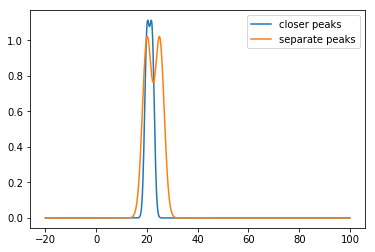

In [16]:
y=np.zeros((Nw,NT))
plt.figure()
for ind, w in enumerate (width):
        y[ind] = gauss(EaxisT, 20, 1, w)+gauss(EaxisT, 20+ind, 1, w)
#         plt.plot(EaxisT,y[ind])
plt.show()
# y_delta[1000] = y_delta[1200] = 1.
plt.figure()
# plt.plot(EaxisT,y[0])

plt.plot(EaxisT,y[2], label='closer peaks')
plt.plot(EaxisT,y[-1], label='separate peaks')
plt.legend()
plt.show()

In [17]:
import srins.powder.scaling as scaling
import random

# noisy (experimental) data creation

* when both resolution are good

In [18]:
ini_uZw = np.zeros(NT)
ini_vZw = np.zeros(NT)

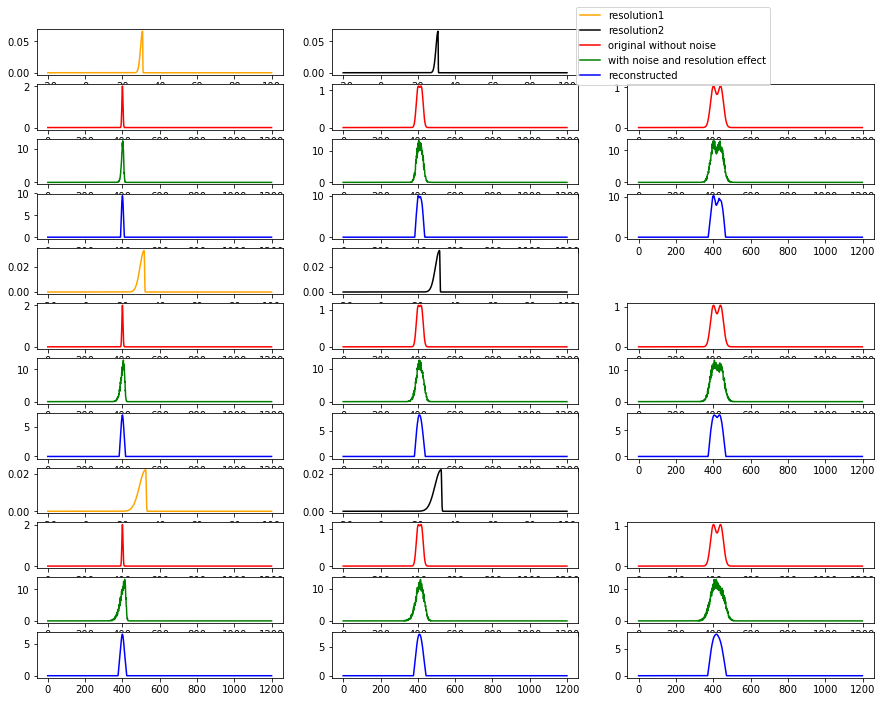

In [24]:
n1=0.0009 #[0.002 ,0.004, 0.006, 0.008, 0.01, 0.02]
plt.figure(figsize=(15,20))
for ind1, i1 in enumerate (np.arange(0,Nw, 2)):
    plt.subplot(20,3, (ind1*12)+1)
    res_1,=plt.plot(EaxisT, res1[ind1][500], label='better resolution', color='orange' )
    plt.subplot(20,3, (ind1*12)+2)
    res_2,=plt.plot(EaxisT, res1[ind1][500], label='better resolution', color='black' )
    for ind, i in enumerate(np.arange(0,Nw, 2)):
        scaleY1=scaling.scale(np.dot(y[i], res1[ind1]), 0, 10)
        scaleY2=scaling.scale(np.dot(y[i], res1[ind1]), 0, 10)
        r=[random.uniform(-1, 1) for _ in range(0, y[i].size)]
        nP1=np.sqrt(scaleY1)*np.abs(r)
        nP2=np.sqrt(scaleY2)*np.abs(r)
        d1= scaleY1+nP1
        d2= scaleY2+nP2
        g1=np.hstack((d1,d2))
        COMres=np.hstack((res1[ind1],res1[ind1]))
        RF_Tw = np.transpose(COMres)
        mw = F(RF_Tw, COMres)
        max_deltaw = 2. / LA.norm(mw, ord=1)
        delta=max_deltaw*0.8
        neu_Nw =np.linalg.norm(d1, 2)**2 / 2/delta/np.linalg.norm(d1,1)
        value=np.nanmean(nP1)
        RVw, RUw, errorw, itw, errorBLw = splb.bregman_NS(g1, COMres, ini_vZw, ini_uZw, neu_Nw, max_deltaw, 'errorModel', value, maxIter=6)
        plt.subplot(20,3,(ind1*6)+3+ (ind1*6)+ind+1)
        ini,=plt.plot(y[i], color='red')
    #     plt.legend(['original without noise'])
        plt.subplot(20,3,(ind1*6)+3+ (ind1*6)+3+ind+1)
        exp,=plt.plot(d1, color='green')
    #     plt.legend(['with noise and resolution effect'])
        plt.subplot(20,3,(ind1*6)+3+ (ind1*6)+6+ind+1)
        rec,=plt.plot(RUw, color='blue')
plt.legend([res_1,res_2, ini, exp, rec],['resolution1','resolution2', 'original without noise', 'with noise and resolution effect', 'reconstructed'],bbox_to_anchor=(0.6, 14.8) )
plt.show()